# Простейшая рекуррентная сеть
В этом ноутбуке мы пройдемся по основам работы с RNN. Сегодня займемся задачей генерации текста. 

In [2]:
import warnings
from typing import Iterable, Tuple
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical

warnings.filterwarnings("ignore")

В качестве обучающего датасета возьмем набор из 120 тысяч анекдотов на русском языке. 
[Ссылка на данные](https://archive.org/download/120_tysyach_anekdotov) и [пост на хабре про тематическое моделирование](https://habr.com/ru/companies/otus/articles/723306/)

In [3]:
with open(r"../../data/anek_djvu.txt", "r", encoding="utf-8") as f:
    text = f.read()
text[118:500]

'|startoftext|>Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!\n\n<|startoftext|>- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...\n\n<|startoftext|>- А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От со'

Мы не хотим моделировать все подряд, поэтому разобьем датасет на отдельные анекдоты.  

In [4]:
def cut_data(text):
    return text.replace("\n\n", "").split("<|startoftext|>")[1:]

In [5]:
cut_text = cut_data(text)

In [6]:
cut_text[1:6]

['Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!',
 '- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...',
 '- А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От собственного храпа по крайней мере еще ни разу не просыпался.- Ну, так у жены спроси.- А жена и подавно не знает. У нее странная привычка после замужества возникла: как спать ложится - беруши вставляет.',
 'Поссорилась с мужем. Пока он спал, я мысленно развелась с ним, поделила имущество, переехала, поняла, что жить без него не могу, дала последний шанс, вернулась. В итоге, ложусь спать уже счастливой женщиной.',
 'Если тебя посещают мысли о смерти - это еще полбеды. Беда - это когда смерть посещают мысли о тебе...']

Сделаем для начала самую простую модель с токенами на уровне символов. Это значит, что каждому символу в тексте ставится в соответствие некоторое число. Некоторые способы токенизации используют части слов или, наоборот, части бинарного представления текста.

In [7]:
unique_chars = tuple(set(text))
int2char = dict(enumerate(unique_chars))
char2int = {ch: ii for ii, ch in int2char.items()}


Напишем функции для энкодинга и декодинга нашего текста. Они будут преобразовывать список символов в список чисел и обратно.

In [9]:
def encode(sentence, vocab):
    return [vocab[x] for x in sentence] # List of ints 

def decode(tokens, vocab):
    return [vocab[x] for x in tokens]# list of strings

In [12]:
# Проверьте, что энеодинг и декодинг работают
t = encode(cut_text[0], char2int)
print(encode(cut_text[0], char2int))
print(decode(t, int2char))

[51, 127, 26, 131, 9, 127, 118, 68, 184, 79, 205, 14, 90, 26, 141, 118, 42, 14, 127, 118, 208, 26, 127, 102, 127, 118, 196, 40, 41, 110, 56, 127, 196, 118, 56, 184, 66, 90, 110, 184, 205, 14, 208, 207, 118, 208, 184, 79, 90, 79, 90, 118, 54, 205, 56, 14, 110, 184, 26, 131, 56, 91, 79, 90, 118, 9, 26, 184, 102, 90, 89, 184, 79, 90, 158, 118, 123, 184, 9, 118, 102, 208, 205, 118, 40, 110, 127, 212, 19, 79, 184, 56, 127, 141, 118, 66, 26, 90, 56, 165]
['Т', 'о', 'л', 'ь', 'к', 'о', ' ', 'з', 'а', 'м', 'е', 'т', 'и', 'л', ',', ' ', 'ч', 'т', 'о', ' ', 'с', 'л', 'о', 'в', 'о', ' ', '"', 'п', '@', 'р', 'н', 'о', '"', ' ', 'н', 'а', 'б', 'и', 'р', 'а', 'е', 'т', 'с', 'я', ' ', 'с', 'а', 'м', 'и', 'м', 'и', ' ', 'ц', 'е', 'н', 'т', 'р', 'а', 'л', 'ь', 'н', 'ы', 'м', 'и', ' ', 'к', 'л', 'а', 'в', 'и', 'ш', 'а', 'м', 'и', '.', ' ', 'К', 'а', 'к', ' ', 'в', 'с', 'е', ' ', 'п', 'р', 'о', 'д', 'у', 'м', 'а', 'н', 'о', ',', ' ', 'б', 'л', 'и', 'н', '!']


Просто представления символов в виде числа не подходят для обучения моделей. На выходе должны быть вероятности всех возможных токенов из словаря. Поэтому модели удобно учить с помощью энтропии. К тому же, токены часто преобразуют из исходного представления в эмбеддинги, которые также позволяют получить более удобное представление в высокоразмерном пространстве. 

В итоге векторы в модели выглядят следующим образом:
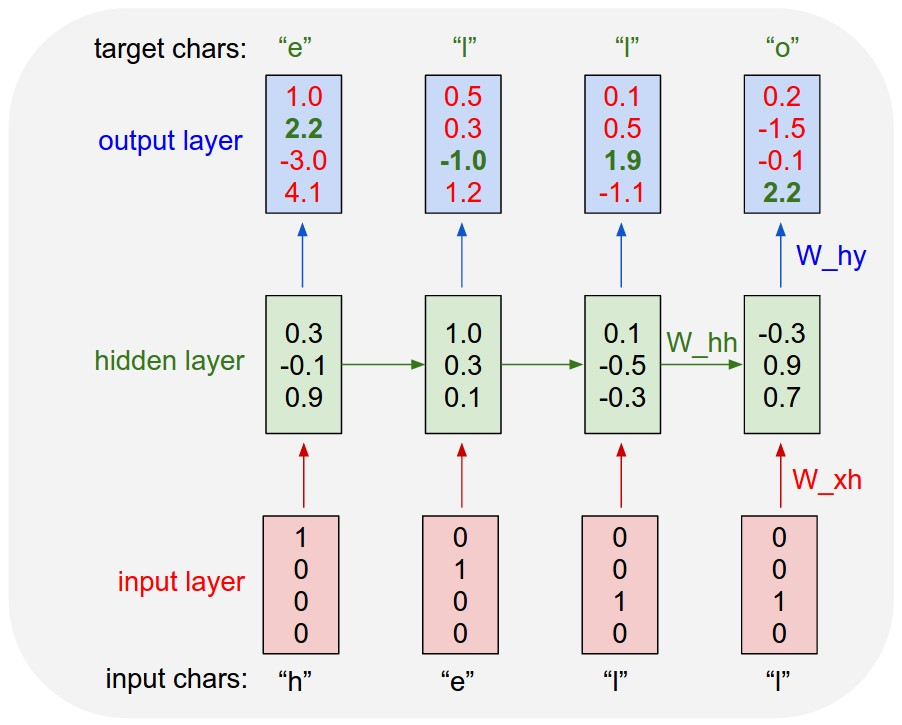

Задание: реализуйте метод, который преобразует батч в бинарное представление.

In [78]:
def one_hot_encode(int_words: torch.Tensor, vocab_size: int) -> torch.Tensor:
    """Encodes batch of sentences into binary values"""
    words_one_hot = torch.zeros(
        # init one hot tensor.
        (int_words.numel(),vocab_size), dtype=float
    )
    print(words_one_hot)
    words_one_hot[torch.arange(words_one_hot.shape[0], len(int_words.flatten()))] = 1
    words_one_hot = words_one_hot.reshape((int_words.shape[0], int_words.shape[1], vocab_size))
    # your code: make from int one hot vector for each element of input tensor. Size bxseq_len -> b x seq_len x vocab_size
    return words_one_hot

Проверьте ваш код.

In [79]:
test_seq = torch.tensor([[2, 6, 4, 1], [0, 3, 2, 4]])
test_one_hot = one_hot_encode(test_seq, 8)

print(test_one_hot)

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64)


Однако, наши последовательности на самом деле разной длины. Как же объединить их в батч?

Реализуем два необходимых класса: 
- токенайзер, который будет брать текст, кодировать и декодировать символы. Еще одно, что будет реализовано там - добавлено несколько специальных символов (паддинг, конец последовательности, начало последовательности).
- Датасет, который будет брать набор шуток, используя токенайзер, строить эмбеддинги и дополнять последовательность до максимальной длины.

In [61]:
class Tokenizer:
    def __init__(self, cut_text, max_len: int = 512):
        self.text = text
        self.max_len = max_len
        self.specials = ['<pad>', '<bos>', '<eos>']
        unique_chars = tuple(set(text))
        self.int2char = dict(enumerate(tuple(set(text))))
        self.char2int = {ch: ii for ii, ch in int2char.items()}
        self._add_special("<pad>")
        self._add_special('<bos>')
        self._add_special('<eos>')
    
    def _add_special(self, symbol) -> None:
        # add special characters to yuor dicts
        sym_mun = len(self.char2int)
        self.char2int[symbol] = sym_mun
        self.int2char[sym_mun] = symbol

    @property
    def vocab_size(self):
        return len(self.char2int)

        
    def decode_symbol(self, el):
        return self.int2char[el]
        
    def encode_symbol(self, el):
        return self.char2int[el]
        
    def str_to_idx(self, chars):
        return [self.char2int[sym] for sym in chars]

    def idx_to_str(self, idx):
        return [self.int2char[i] for i in idx]

    def encode(self, chars):
        chars = ['<bos>'] + list(chars) + ['<eos>']
        return self.str_to_idx(chars)

    def decode(self, idx):
        chars = self.idx_to_str(idx)
        return "".join(chars)


In [62]:
class JokesDataset(Dataset):
    def __init__(self, tokenizer, cut_text, max_len: int = 512):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.cut_text = cut_text
        self.pad_index = self.tokenizer.encode_symbol("<pad>")

    def __len__(self):
        return len(self.cut_text)
        
    def __getitem__(self, item):
        # pad your sequence and make a final sample. You can skip padding and pad sequences with torch special method.
        encoded = self.tokenizer.encode(self.cut_text[item])
        padded = torch.full((self.max_len,), self.pad_index, dtype=torch.int64)
        padded[:len(encoded) ] = torch.tensor(encoded)
        return encoded, len(encoded)

# Optionally add new methods to your dataset class

In [63]:
tokenizer = Tokenizer(text)
dataset = JokesDataset(tokenizer, cut_text, 512)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Вопрос: А как бы мы должны были разделять данные на последовательности и батчи в случае, если бы использовался сплошной текст?

In [65]:
# Задание: проверьте свой датасет
for i in dataloader:
    print(i)
    break

RuntimeError: each element in list of batch should be of equal size

Теперь реализуем нашу модель. 
Необходимо следующее:
 - Используя токенайзер, задать размер словаря
 - Задать слой RNN с помощью torch.RNN. Доп.задание: создайте модель, используя слой LSTM.
 - Задать полносвязный слой с набором параметров: размерность ввода — n_hidden; размерность выхода — размер словаря. Этот слой преобразует состояние модели в логиты токенов.
 - Определить шаг forward, который будет использоваться при обучении
 - Определить метод init_hidden, который будет задавать начальное внутреннее состояние. Инициализировать будем нулями.
 - Определить метод inference, в котором будет происходить генерация последовательности из префикса. Здесь мы уже не используем явные логиты, а семплируем токены на их основе.


In [ ]:
class CharRNN(nn.Module):
    def __init__(
        self,
        tokenizer,
        hidden_dim: int = 256,
        num_layers: int = 2,
        drop_prob: float = 0.5,
        max_len: int = 512,
    ) -> None:
        super().__init__()
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.drop_prob = drop_prob
        self.max_len = max_len
        # create mappings
        self.tokenizer = tokenizer

        ## define the LSTM, dropout and fully connected layers
        self.rnn = # your code
        self.dropout = # your code
        self.fc = # your code

    def forward(
        self, x: torch.Tensor, lengths: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        # one-hot encode your sequence
        packed_embeds = # pack your sequence. This helps with the efficiency. Use torch function pack_padded_sequence
        outputs, hidden = # run you model
        out, lengths = # pad sequence back
        ## Get the output for classification.
        out = 
        return out

    def inference(self, prefix='<bos> ', device="cpu"):
        tokens =  # encode prefix
        # create embeddings 
        # generate hidden and logits for prefix
               
        new_tokens = # sample new token from logits
        tokens = torch.cat([tokens, new_tokens], dim=1)

        # 2 stopping conditions: reaching max len or getting <eos> token
        while tokens.shape[1] < self.max_len:
            # YOUR CODE: generate sequence one by one
        return self.tokenizer.decode(tokens.squeeze())

Зададим параметры для обучения. Можете варьировать их, чтобы вам хватило ресурсов.

In [ ]:
batch_size = 4
seq_length = 512
n_hidden = 64
n_layers = 4
drop_prob = 0.1
lr = 0.1

Напишите функцию для одного тренировочного шага. В этом ноутбуке сам процесс обучения модели достаточно тривиален, поэтому мы не будем использовать сложные функции для обучающего цикла. Вы же, однако, можете дописать их.

In [ ]:
def training_step(
    model: CharRNN,
    train_batch: Tuple[torch.Tensor, torch.Tensor],
    vocab_size: int,
    criterion: nn.Module,
    optimizer,
    device="cpu"
) -> torch.Tensor:
    optimizer.zero_grad()
    batch_size, seq_len = train_batch[0].shape
    # train step. Ensure the model output and 
    return loss

Инициализируйте модель, функцию потерь и оптимизатор.

In [ ]:
model = CharRNN(tokenizer, n_hidden, n_layers, drop_prob)
hidden = None
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)


Проверьте необученную модель: она должна выдавать бессмысленные последовательности

In [ ]:
# Your code: test inference

In [ ]:
def plot_losses(losses):
    clear_output()
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

Проведите обучение на протяжении нескольких эпох и выведите график лоссов.

In [ ]:
losses = []
num_epochs = 5

for epoch in range(1, num_epochs + 1):
    # your code: run model traininig for n epochs
    
    plot_losses(losses)
    torch.save(model.state_dict(), "rnn.pt")

In [ ]:
[model.inference("") for _ in range(10)]

In [ ]:
# Дополнительная секция

Теперь попробуем написать свой собственный RNN. Это будет довольно простая модель с одним слоем.


In [ ]:
# YOUR CODE: custom model nn.Module, changed CharRNN, etc